# 01. Load Data

02. Load CSV files into Dataframes and optionally process

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

import datautil as du
from analysis_util_01 import MMM, MMMChannelsStraight, MMMChannelsStraightConfounder, MMMFbGoogleMetrics

%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = du.get_collected_dataframe()
# create an index col for easy plotting
data['dt'] = data['date']
data.set_index('dt', inplace=True)
data.head()

,date,spend_fb,impressions_fb,clicks_fb,purchases_fb,spend_google,impressions_google,clicks_google,sales
dt,,,,,,,,,
2023-09-13,2023-09-13,1044.52,158057.0,2863.0,7.0,17731.458630,350223.0,3818.0,125087.3010
2023-09-14,2023-09-14,746.37,110849.0,1691.0,6.0,15614.170441,206164.0,3640.0,142865.4874
2023-09-15,2023-09-15,0.00,0.0,0.0,8.0,11892.922135,240704.0,3075.0,200679.1577
2023-09-16,2023-09-16,0.00,0.0,0.0,8.0,10958.380107,247014.0,2979.0,120231.9569
2023-09-17,2023-09-17,0.00,0.0,0.0,6.0,14914.932425,249658.0,3666.0,166163.5059


# 02. Model and comparisons

In [3]:
models = {}

## Add fitted models

In [4]:
def add_model(models, name, mmm):
    models[name] = mmm
    mmm.fit(progressbar=False)
    with mmm.model:
        if "log_likelihood" not in mmm.idata:
            pm.compute_log_likelihood(mmm.idata, var_names=["y"], progressbar=False)

In [5]:
add_model(models, "plain_fb", MMMChannelsStraight(data, ["spend_fb"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [6]:
add_model(models, "plain_google", MMMChannelsStraight(data, ["spend_google"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
add_model(models, "plain_google_fb", MMMChannelsStraight(data, ["spend_google"], ["spend_fb"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, sigma, beta]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [8]:
add_model(models, "plain_fb_google_intercept", MMMChannelsStraight(data, ["spend_fb", "spend_google"], allowIntercept=True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, sigma, beta]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [9]:
add_model(models, "plain_fb_intercept", MMMChannelsStraight(data, ["spend_fb"], allowIntercept=True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, sigma, beta]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [10]:
add_model(models, "plain_google_intercept", MMMChannelsStraight(data, ["spend_google"], allowIntercept=True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, sigma, beta]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [11]:
add_model(models, "plain_fb_google_intercept_adstock", MMMChannelsStraight(data, ["spend_fb", "spend_google"], allowIntercept=True, allowAdstockAndSat=True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, sigma, beta, alpha, lam]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [12]:
add_model(models, "fb_google_confounder_intercept", MMMChannelsStraightConfounder(data, channelnames=["spend_fb", "spend_google"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, intercept, beta_fb, beta_google, beta_fb_google, spend_google_0, sigma_google]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [13]:
add_model(models, "channelmetrics_clicks_fb_clicks_google", mmm = MMMFbGoogleMetrics(data, channelnames=["spend_fb", "spend_google"], fb_metric="clicks_fb", google_metric="clicks_google"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, sigma, beta_fb, beta_google]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [14]:
add_model(models, "channelmetrics_impressions_fb_clicks_google", mmm = MMMFbGoogleMetrics(data, channelnames=["spend_fb", "spend_google"], fb_metric="impressions_fb", google_metric="clicks_google"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, sigma, beta_fb, beta_google]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [15]:
add_model(models, "channelmetrics_impressions_fb_impressions_google", mmm = MMMFbGoogleMetrics(data, channelnames=["spend_fb", "spend_google"], fb_metric="impressions_fb", google_metric="impressions_google"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, sigma, beta_fb, beta_google]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [16]:
add_model(models, "channelmetrics_purchases_fb_clicks_google", mmm = MMMFbGoogleMetrics(data, channelnames=["spend_fb", "spend_google"], fb_metric="purchases_fb", google_metric="clicks_google"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, sigma, beta_fb, beta_google]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Compare models

In [17]:
df_comp_loo = az.compare({k: v.idata for k, v in models.items()})
df_comp_loo

/root/.cache/pypoetry/virtualenvs/mmm-experiments-PvlroFJ7-py3.12/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/mmm-experiments-PvlroFJ7-py3.12/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observati

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
channelmetrics_purchases_fb_clicks_google,0,-22.373739,5.199513,0.000000,9.667761e-01,13.425409,0.000000,False,log
channelmetrics_impressions_fb_clicks_google,1,-100.550744,10.790150,78.177006,0.000000e+00,25.443533,20.515322,True,log
channelmetrics_clicks_fb_clicks_google,2,-104.829769,11.311648,82.456030,0.000000e+00,25.450330,20.703604,False,log
plain_fb_google_intercept_adstock,3,-117.801391,17.086306,95.427652,3.322386e-02,35.031267,33.693875,True,log
channelmetrics_impressions_fb_impressions_google,4,-123.300552,11.690911,100.926813,0.000000e+00,29.215828,25.023117,True,log
fb_google_confounder_intercept,5,-125.168609,13.593600,102.794870,0.000000e+00,32.672485,30.816612,True,log
plain_fb_google_intercept,6,-126.579931,15.415762,104.206193,0.000000e+00,33.625231,31.775145,True,log
plain_fb_intercept,7,-136.947055,10.103442,114.573316,0.000000e+00,33.526847,31.692961,True,log
plain_google_fb,8,-156.369704,11.886992,133.995965,0.000000e+00,32.719647,31.574450,True,log
plain_google_intercept,9,-157.015011,12.922283,134.641273,0.000000e+00,33.119304,31.977496,True,log


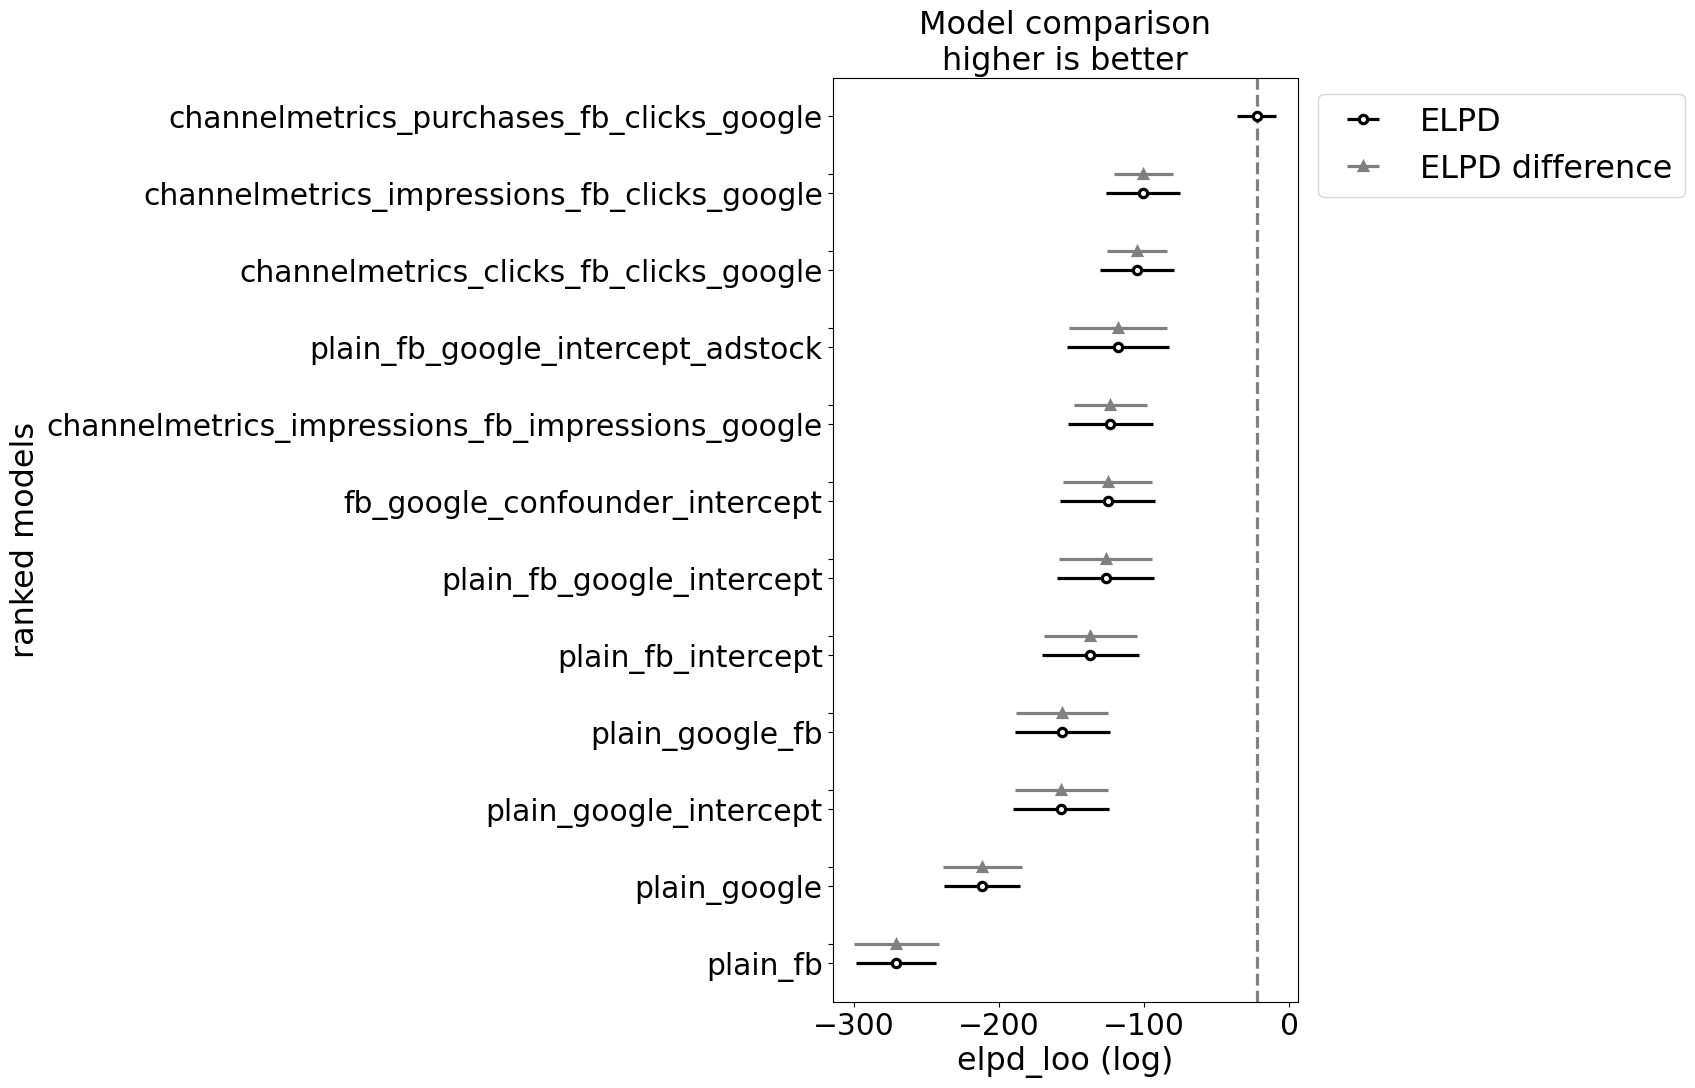

In [18]:
az.plot_compare(df_comp_loo, insample_dev=False);